# Backtest a  Strategy

In [1]:
from smartbots.crypto.historical_downloader import historical_downloader, save_test_data
import datetime as dt
import pandas as pd
from smartbots.engine.data_reader import read_data_to_dataframe
from smartbots.engine.portfolio_constructor import Portfolio_Constructor

C:\Users\jcarpio\Anaconda3\envs\my38\lib\site-packages\arctic\store\_pandas_ndarray_store.py:8: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## 1) Download Historical Data from Data Provider and save into the database.
If you already have the data in a database, you can skip this step and go to the next.

Dependings of the symbols and the length of the data, the data loader will take some time to complete. Be pacience.

If there are already some data in the database, it will update only the new data.


In [4]:
# Parameters
test = True  # set False if you have the keys for the exchange and you copy it on docker/compose.env.

if test:
    provider ='test'
    save_test_data()
else:
    provider = 'kucoin'
    symbols = ["BTC-USDT","ETH-USDT"] # List of symbols to download from provider
    start_date = dt.datetime(2022,8,1) # Start date of data to download
    end_date = dt.datetime.utcnow() # End date of data to download
    interval = '1min' # Interval of data to download
    historical_downloader(symbols=symbols,start_date=start_date, end_date=dt.datetime.utcnow(),
           provider=provider,clean_symbols_database=[],interval=interval)

Pandas dataframe BTC-USDT_202201 contains Objects, saving as Blob
Pandas dataframe BTC-USDT_202202 contains Objects, saving as Blob
Pandas dataframe BTC-USDT_202203 contains Objects, saving as Blob
Pandas dataframe BTC-USDT_202204 contains Objects, saving as Blob
Pandas dataframe BTC-USDT_202205 contains Objects, saving as Blob
Pandas dataframe BTC-USDT_202206 contains Objects, saving as Blob
Pandas dataframe BTC-USDT_202207 contains Objects, saving as Blob
Pandas dataframe BTC-USDT_202208 contains Objects, saving as Blob


Symbol BTC-USDT saved.


Pandas dataframe ETH-USDT_202201 contains Objects, saving as Blob
Pandas dataframe ETH-USDT_202202 contains Objects, saving as Blob
Pandas dataframe ETH-USDT_202203 contains Objects, saving as Blob
Pandas dataframe ETH-USDT_202204 contains Objects, saving as Blob
Pandas dataframe ETH-USDT_202205 contains Objects, saving as Blob
Pandas dataframe ETH-USDT_202206 contains Objects, saving as Blob
Pandas dataframe ETH-USDT_202207 contains Objects, saving as Blob
Pandas dataframe ETH-USDT_202208 contains Objects, saving as Blob


Symbol ETH-USDT saved.


## 2) Read Historical Data from Database and Visualize it.


In [29]:
provider = 'kucoin'
symbols = ["BTC-USDT","ETH-USDT"] # List of symbols to download from provider
start_date = dt.datetime(2022,1,1) # Start date of data to download
end_date = dt.datetime.utcnow() # End date of data to download
df = read_data_to_dataframe(symbols[0], provider,start_date=start_date,end_date=end_date)

<AxesSubplot:xlabel='date'>

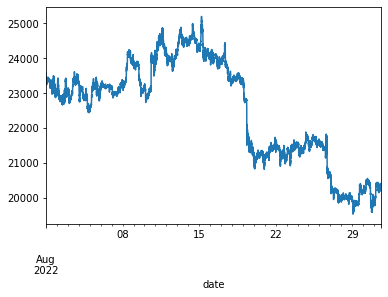

In [30]:
df.close.plot()

## 3) BackTesting

### Settings

In [4]:
provider = 'kucoin'
start_date = dt.datetime(2022,8,1) # Start date for backtesting

strategy1 = {'id': 1, # unique id for strategy to run
             'strategy': 'Simple_Avg_Cross', # strategy name, create in smartbots/crypto/strategies
             'params': {'ticker': 'BTC-USDT',
             'short_period': 10,
             'long_period': 50,
             'quantity': 0.1,
             'limit_save_values':1000}}


conf_portfolio = {'Name': 'PortfolioCrypto1',
                  'Data_Sources': 
                  [{'ticker': 'BTC-USDT',
                   'event_type': 'bar',
                   'historical_source': 'mongoDB',
                   'historical_library': f'{provider}_historical_1min'}],
                   'Strategies': 
                    [strategy1]}

In [5]:
portfolio = Portfolio_Constructor(conf_portfolio, run_real=False, asset_type='crypto',
                                             send_orders_to_broker=False, start_date=start_date)
portfolio.run_simulation() # backtest 

info_port = portfolio.get_saved_values_strategy() # read change of positions

BTC-USDT_202208


## Stats

In [33]:
t = 'BTC-USD'
df_orders = pd.DataFrame({'events':portfolio.orders},index =[d.datetime for d in portfolio.orders])

df_bar = pd.DataFrame({'events':df.bar},index =df.index)


In [35]:
# From bar events create Ticks
from smartbots.events import Tick
dia = None
ticks = []
ant_bar = None
for b in df_bar.events:
    if dia is None:
        dia = b.datetime.day
    if dia != b.datetime.day:
        dia = b.datetime.day
        ticks.append(Tick(tick_type='close_day',price=ant_bar.close,
                         ticker=ant_bar.ticker,datetime=ant_bar.datetime ))
    ant_bar = b
df_ticks = pd.DataFrame({'events':ticks},index =[d.datetime for d in ticks])    
df_join = pd.concat([df_orders,df_bar,df_ticks])
df_join =df_join.sort_index()

In [38]:
df_join.to_pickle('example_for_equity.pkl', compression='gzip')